<font color=gray size=5> Import Necessary Libraries </font>

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

<font color=gray size=5> Take a look at set </font>

In [2]:
train_dataset = h5py.File('train_signs.h5', "r")
print np.array(train_dataset)
print np.array(train_dataset['train_set_y']).shape

[u'list_classes' u'train_set_x' u'train_set_y']
(1080,)


<font color=gray size=5> Load data set </font>

In [3]:
def load_dataset_my():
    train = h5py.File('train_signs.h5','r')
    train_x = np.array(train['train_set_x'][:])
    train_y = np.array(train['train_set_y'][:])
    
    test = h5py.File('test_signs.h5','r')
    test_x = np.array(test['test_set_x'][:])
    test_y = np.array(test['test_set_y'][:])
    
    classes = np.array(test['list_classes'][:])
    
    train_y = train_y.reshape((1,train_y.shape[0]))
    test_y = test_y.reshape((1,test_y.shape[0]))
    
    return train_x,train_y,test_x,test_y,classes

In [4]:
train_x,train_y,test_x,test_y,classes = load_dataset_my()

y = 2


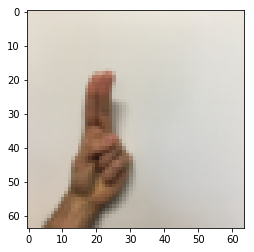

In [5]:
plt.imshow(train_x[10,:,:,:])
print 'y = ' + str(np.squeeze(train_y[:,10]))

<font color=gray size=5>Lable -> One-hot</font>

In [6]:
def convert_to_onehot(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y   

In [7]:
print np.arange(12).reshape((3,4))
np.arange(12).reshape((3,4))[1]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([4, 5, 6, 7])

In [8]:
X_train = train_x/255.
X_test = test_x/255.
Y_train = convert_to_onehot(train_y, 6).T
Y_test = convert_to_onehot(test_y,6).T
conv_layers = {}

In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


<font color=gray size=5>Create placeholders</font>

In [10]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    return X,Y

<font color=gray size=5>Initialize trainable parameters</font>

In [11]:
def initialize_parameters():
    W1 = tf.get_variable('W1',[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable('W2',[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer())
    parameters = {'W1':W1,'W2':W2}
    return parameters

<font color=gray size=5>Define model</font>

<font color=gray size=5>
Conv2D: stride 1, padding is "SAME" <br>
ReLU<br>
Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"<br>
Conv2D: stride 1, padding is "SAME"<br>
ReLU<br>
Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"<br>
Flatten the previous output.<br>
FULLYCONNECTED (FC) layer<br>
</font>

In [12]:
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    
    return Z3    

<font color=gray size=5>Define cost</font>

In [14]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

<font color=gray size=5>Randomly create minibatches</font>

In [16]:
def random_mini_batches(X,Y,minibatch_size=64):
    m=X.shape[0]
    mini_batches=[]
    #shuffle
    P=list(np.random.permutation(m))
    shuffled_X=X[P,:,:,:]
    shuffled_Y=Y[P,:]
    #split
    for k in range(int(math.floor(m/minibatch_size))):
        mini_batch_X = shuffled_X[minibatch_size*k:minibatch_size*(k+1),:,:,:]
        mini_batch_Y = shuffled_Y[minibatch_size*k:minibatch_size*(k+1),:]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % minibatch_size != 0:
        mini_batch_X = shuffled_X[minibatch_size*(k+1):,:,:,:]
        mini_batch_Y = shuffled_Y[minibatch_size*(k+1):,:]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

<font color=gray size=5>Run</font>

In [17]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,minibatch_size=64,num_epochs=100,Print=True):
    tf.reset_default_graph()
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]
    
    X,Y=create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    cost=compute_cost(Z3,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init=tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost=0.
            num_minibatches=int(m/minibatch_size)
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost/num_minibatches
                
            if Print and epoch % 5 ==0:
                print epoch,minibatch_cost
            
            costs.append(minibatch_cost)
        #    
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        #
        predict_op = tf.argmax(Z3,1)
        correct_op = tf.equal(predict_op,tf.argmax(Y,1)) 
        
        Accuracy = tf.reduce_mean(tf.cast(correct_op,'float'))
        print Accuracy
        
        Train_acc = Accuracy.eval({X: X_train, Y: Y_train})
        Test_acc = Accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", Train_acc)
        print("Test Accuracy:", Test_acc)
                
        return Train_acc, Test_acc, parameters
    
    

0 1.9101266712
5 1.69123950601
10 1.29251982272
15 1.16193010658
20 1.00655050948
25 0.936567794532
30 0.843614902347
35 0.799633141607
40 0.763278353959
45 0.748226009309
50 0.664053756744
55 0.616929883137
60 0.607394229621
65 0.585365599021
70 0.588023912162
75 0.622934674844
80 0.62246234715
85 0.519499070942
90 0.483531083912
95 0.46646746248
100 0.439361006953
105 0.460040688515
110 0.519738441333
115 0.436620693654
120 0.405171018094
125 0.427923144773
130 0.392739809118
135 0.422709055245
140 0.406304327771
145 0.395105692558
150 0.415036036633
155 0.389879175462
160 0.351677954197
165 0.367208481766
170 0.336361470632
175 0.328760040924
180 0.368848279119
185 0.408874556422
190 0.324499025941
195 0.303653088398


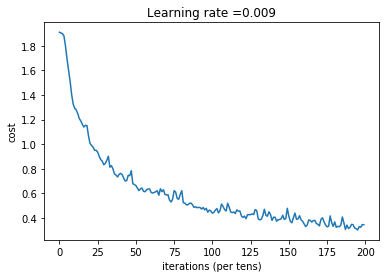

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 0.88333333)
('Test Accuracy:', 0.75)


In [18]:
Train_acc, Test_acc, parameters=model(X_train,Y_train,X_test,Y_test,num_epochs=200)

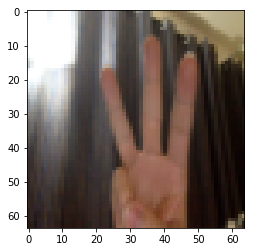

In [19]:
fname = "test3.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)

In [20]:
X=np.reshape(my_image,(1,64,64,3))
X_test = X/255.
Y_test = np.array([0,0,0,1,0,0])

In [21]:
Y_test = np.reshape(Y_test,(1,6))
X_test.shape
Y_test.shape

(1, 6)

In [ ]:
Train_acc, Test_acc, parameters=model(X_train,Y_train,X_test,Y_test,num_epochs=100)
